# 基于MindSpore的ResNet50模型中药炮制饮片质量判断任务

## 案例介绍

中药炮制是根据中医药理论，依照临床辨证施治用药的需要和药物自身性质，以及调剂、制剂的不同要求，**将中药材制备成中药饮片所采取的一项制药技术**。平时我们老百姓能接触到的中药，主要指自己回家煎煮或者请医院代煎煮的中药，都是中药饮片，也就是中药炮制这个技术的结果。而中药炮制饮片，大部分涉及到水火的处理，一定需要讲究“程度适中”，炮制火候不够达不到最好药效，炮制火候过度也会丧失药效。
- “生品”一般是指仅仅采用简单净选得到的饮片，通常没有经过火的处理，也是后续用火加工的原料。
- “不及”就是“炮制不到位”，没有达到规定的程度，饮片不能发挥最好的效果。
- “适中”是指炮制程度刚刚好，正是一个最佳的炮制点位，也是通常炮制结束的终点。
- “太过”是指炮制程度过度了，超过了“适中”的最佳状态，这时候的饮片也会丧失药效，不能再使用了。

过去的炮制饮片程度的判断，都是采用的老药工经验判断，但随着老药工人数越来越少，这种经验判断可能存在“失传”的风险。而随着人工智能的发展，使用深度神经网络模型对饮片状态进行判断能达到很好的效果，可以很好的实现经验的“智能化”和经验的传承。

## 模型简介

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。在CIFAR-10数据集上使用56层网络与20层网络训练，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。
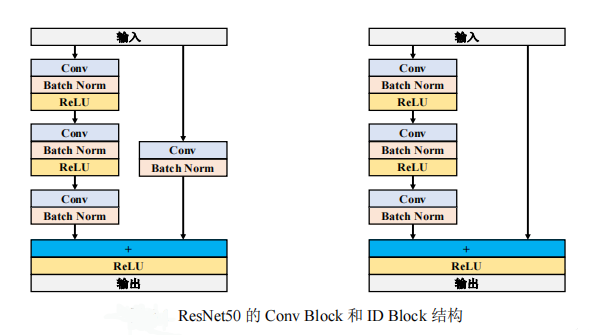

## 环境准备

本案例的运行环境为：

| Python | MindSpore |
| :----- | :-------- |
| 3.9 | 2.7.1     |

In [ ]:
# 检查mindspore版本是否为2.7.1，如果不是则取消下个单元格注释进行安装
!pip show mindspore

如果你在如[昇思大模型平台](https://xihe.mindspore.cn/training-projects)、[华为云ModelArts](https://www.huaweicloud.com/product/modelarts.html)、[启智社区](https://openi.pcl.ac.cn/)等算力平台的Jupyter在线编程环境中运行本案例，可取消如下代码的注释，进行依赖库安装：

In [ ]:
# 安装mindspore==2.7.1版本，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
# !pip uninstall mindspore -y
# %env MINDSPORE_VERSION=2.7.1
# !pip install mindspore==2.7.1 -i https://repo.mindspore.cn/pypi/simple --trusted-host repo.mindspore.cn --extra-index-url https://repo.huaweicloud.com/repository/pypi/simple

In [ ]:
import os
import random
import shutil
import numpy as np
import mindspore as ms
import matplotlib.pyplot as plt
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms

from PIL import Image
from download import download
from typing import Type, Union, List, Optional
from mindspore.common.initializer import Normal
from mindspore.dataset import ImageFolderDataset
from mindspore import (Tensor, nn, train, mint, context, load_checkpoint, load_param_into_net, ops,)

其他场景可参考[MindSpore安装指南](https://www.mindspore.cn/install)进行环境搭建。

## 数据加载与预处理

我们使用“中药炮制饮片”数据集，该数据集由成都中医药大学提供，共包含中药炮制饮片的 3 个品种，分别为：蒲黄、山楂、王不留行，每个品种又有着4种炮制状态：生品、不及适中、太过，图片尺寸为4K，图片格式为jpg，共786张图片。

#### **数据下载**

In [ ]:
# 数据集下载链接
url = "https://obs-xihe-beijing4.obs.cn-north-4.myhuaweicloud.com/jupyter/dataset/zhongyiyao/dataset.zip"
if not os.path.exists("dataset"):
    download(url, "dataset", kind="zip")

#### **数据裁剪**
原图片尺寸为4k比较大，我们预处理将图片resize到指定尺寸(1000,1000)。

In [ ]:
data_dir = "dataset/zhongyiyao/zhongyiyao"
new_data_path = "dataset1/zhongyiyao"
if not os.path.exists(new_data_path):
    for path in ['train','test']:
        data_path = data_dir + "/" + path
        classes = os.listdir(data_path)
        for (i,class_name) in enumerate(classes):
            floder_path =  data_path+"/"+class_name
            print(f"正在处理{floder_path}...")
            for image_name in os.listdir(floder_path):
                try:
                    image = Image.open(floder_path + "/" + image_name)
                    image = image.resize((1000,1000))
                    target_dir = new_data_path+"/"+path+"/"+class_name
                    if not os.path.exists(target_dir):
                        os.makedirs(target_dir)
                    if not os.path.exists(target_dir+"/"+image_name):
                        image.save(target_dir+"/"+image_name)
                except:
                    pass

#### **数据集划分**
我们将中药炮制饮片数据集划分为训练集、验证集和测试集，并将数据按类别整理到不同的目录中，以便后续模型训练和评估。

In [ ]:
def split_data(data_dir, test_size=0.2, val_size=0.2, random_seed=42):
    random.seed(random_seed)
    folders = ['train', 'test']
    imgs = []
    labels = []

    for path in folders:
        data_path = os.path.join(data_dir, path)
        classes = os.listdir(data_path)
        for class_name in classes:
            class_dir = os.path.join(data_path, class_name)
            if not os.path.isdir(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    imgs.append(img_path)
                    labels.append(class_name)

    data = list(zip(imgs, labels))
    random.shuffle(data)

    total = len(data)
    test_size = int(total * test_size)
    val_size = int(total * val_size)
    train_size = total - test_size - val_size

    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]

    print(f"划分训练集图片数：{len(train_data)}")
    print(f"划分验证集图片数：{len(val_data)}")
    print(f"划分测试集图片数：{len(test_data)}")

    # 创建train, valid, test文件夹并根据划分移动数据
    for split, data_split in zip(['train', 'valid', 'test'], [train_data, val_data, test_data]):
        target_data_dir = os.path.join(data_dir, split)
        if not os.path.exists(target_data_dir):
            os.makedirs(target_data_dir)

        for img_path, label in data_split:
            target_label_dir = os.path.join(target_data_dir, label)
            if not os.path.exists(target_label_dir):
                os.makedirs(target_label_dir)
            # 移动图片文件到目标目录
            target_img_path = os.path.join(target_label_dir, os.path.basename(img_path))
            shutil.move(img_path, target_img_path)
    return train_data, val_data, test_data

def create_data_splits(data_dir):
    train_data, val_data, test_data = split_data(data_dir)
    return train_data, val_data, test_data

data_dir = "dataset1/zhongyiyao"
train_data, val_data, test_data = create_data_splits(data_dir)

#### **定义数据加载方式**
在我们将数据喂进模型之前，可以通过MindSpore提供的多种数据变换（Transforms）方法来增强训练数据的多样性、统一数据尺寸，并进行必要的归一化和标准化操作，确保数据在喂入模型前符合要求，提高模型的训练效果。所有这些变换都通过 .map(...)方法在数据加载时被应用，从而实现了整个数据预处理的Pipeline。
在本案例中我们对数据进行了随机裁剪（RandomCrop）、随机水平翻转（RandomHorizontalFlip）、调整图像尺寸（Resize）、像素值归一化（Rescale）、图像标准化（Normalize）、格式转换（HWC2CHW）等的处理。

In [ ]:
# 如果创建.ipynb_checkpoints文件夹，则删除
def remove_ipynb_checkpoints(data_dir):
    ipynb_checkpoints_dir = os.path.join(data_dir, '.ipynb_checkpoints')
    if os.path.exists(ipynb_checkpoints_dir):
        print(f"删除目录: {ipynb_checkpoints_dir}")
        shutil.rmtree(ipynb_checkpoints_dir)

def create_dataset_zhongyao(dataset_dir, usage, resize, batch_size, workers):
    remove_ipynb_checkpoints(dataset_dir)
    # 使用 ImageFolder 加载数据集
    dataset = ImageFolderDataset(dataset_dir, decode=True)
    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop(700, (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize((resize, resize)),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(ms.int32)
    dataset = dataset.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers
    )

    dataset = dataset.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers
    )

    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

#### **加载数据**
我们接下来为模型训练准备数据，并设置了一些相关的超参数，同时也确保实验的可复现性。

In [ ]:
data_dir = "dataset1/zhongyiyao"
train_dir = data_dir+"/"+"train"
valid_dir = data_dir+"/"+"valid"
test_dir = data_dir+"/"+"test"
batch_size = 32  # 批量大小
image_size = 224  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 12  # 分类数量

seed = 42
ms.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

dataset_train = create_dataset_zhongyao(dataset_dir=train_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_zhongyao(dataset_dir=valid_dir,
                                     usage="valid",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
dataset_test = create_dataset_zhongyao(dataset_dir=test_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

print(f'训练集数据：{dataset_train.get_dataset_size()*batch_size}\n')
print(f'验证集数据：{dataset_val.get_dataset_size()*batch_size}\n')
print(f'测试集数据：{dataset_test.get_dataset_size()*batch_size}\n')

#### **类别标签说明**
由于平台字体问题，无法正确显示中文，这里给出英文标签对应的类别：
- ph-sp：蒲黄-生品
- ph_bj：蒲黄-不及
- ph_sz：蒲黄-适中
- ph_tg：蒲黄-太过
- sz_sp：山楂-生品
- sz_bj：山楂-不及
- sz_sz：山楂-适中
- sz_tg：山楂-太过
- wblx_sp：王不留行-生品
- wblx_bj：王不留行-不及
- wblx_sz：王不留行-适中
- wblx_tg：王不留行-太过

In [ ]:
index_label_dict = {}
classes = os.listdir(train_dir)
if '.ipynb_checkpoints' in classes:
    classes.remove('.ipynb_checkpoints')
for i,label in enumerate(classes):
    index_label_dict[i] = label
label2chin = {'ph_sp':'蒲黄-生品',  'ph_bj':'蒲黄-不及', 'ph_sz':'蒲黄-适中', 'ph_tg':'蒲黄-太过', 'sz_sp':'山楂-生品',
              'sz_bj':'山楂-不及', 'sz_sz':'山楂-适中', 'sz_tg':'山楂-太过', 'wblx_sp':'王不留行-生品', 'wblx_bj':'王不留行-不及',
              'wblx_sz':'王不留行-适中', 'wblx_tg':'王不留行-太过'}
index_label_dict

#### **数据可视化**

In [ ]:
data_iter = next(dataset_val.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(24):
    plt.subplot(3, 8, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(index_label_dict[labels[i]])
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 模型构建

#### **创建分类网络**
处理完数据后，就可以来进行网络的搭建了。我们将最后一层线性映射的输出改为类别数12，以适应数据集。

残差结构是ResNet网络中最重要的结构，由两个分支构成：一个主分支，一个shortcuts。主分支通过堆叠一系列的卷积操作得到，shortcuts从输入直接到输出，主分支的输出与shortcuts的输出相加后通过Relu激活函数后即为残差网络最后的输出。

残差网络结构主要由两种，一种是Building Block，适用于较浅的ResNet网络，如ResNet18和ResNet34；另一种是Bottleneck，适用于层数较深的ResNet网络，如ResNet50、ResNet101和ResNet152。

#### **定义 Building Block**
Building Block结构的主分支有两层卷积网络结构：

- 主分支第一层网络以输入channel为64为例，首先通过一个3×3的卷积层，然后通过Batch Normalization层，最后通过Relu激活函数层，输出channel为64；

- 主分支第二层网络的输入channel为64，首先通过一个3×3的卷积层，然后通过Batch Normalization层，输出channel为64。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Building Block最后的输出。<br>

In [ ]:
class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等
    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = mint.nn.BatchNorm2d(out_channel, momentum=0.9)
        else:
            self.norm = norm
        # 一层卷积
        self.conv1 = mint.nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        # 二层卷积
        self.conv2 = mint.nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, padding=1, bias=False)
        # 接ReLU激活函数
        self.relu = mint.nn.ReLU()
        self.down_sample = down_sample

    # 定义前向传播
    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        sum1 = out + identity
        out = sum1  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

#### **定义 Bottleneck**
Bottleneck在输入相同的情况下Bottleneck结构相对Building Block结构的参数数量更少，更适合层数较深的网络，ResNet50使用的残差结构就是Bottleneck。该结构的主分支有三层卷积结构，分别为1×1的卷积层、3×3卷积层和1×1的卷积层，其中1×1的卷积层分别起降维和升维的作用。

- 主分支第一层网络以输入channel为256为例，首先通过数量为64，大小为的卷积核进行降维，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；

- 主分支第二层网络通过数量为64，大小为的卷积核提取特征，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；

- 主分支第三层通过数量为256，大小的卷积核进行升维，然后通过Batch Normalization层，其输出channel为256。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Bottleneck最后的输出。

In [ ]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍
    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = mint.nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, padding=0, bias=False)
        self.norm1 = mint.nn.BatchNorm2d(out_channel, momentum=0.9)
        self.conv2 = mint.nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.norm2 = mint.nn.BatchNorm2d(out_channel, momentum=0.9)
        self.conv3 = mint.nn.Conv2d(in_channels=out_channel, out_channels=out_channel * self.expansion,
                               kernel_size=1, padding=0, bias=False)
        self.norm3 = mint.nn.BatchNorm2d(out_channel * self.expansion, momentum=0.9)

        self.relu = mint.nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        sum2 = out + identity
        out = sum2  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

#### **构建ResNet网络**
定义make_layer函数，用于构建一组残差块（ResidualBlock 或 ResidualBlockBase），并且根据给定的参数堆叠多个残差块，还可以将多个残差块组合成一个更大的网络模块。

In [ ]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None
    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = nn.SequentialCell([
            mint.nn.Conv2d(in_channels=last_out_channel, out_channels=channel * block.expansion,
                      kernel_size=1, stride=stride, padding=0, bias=False),
            mint.nn.BatchNorm2d(channel * block.expansion, momentum=0.9)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))
    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel))
    return nn.SequentialCell(layers)

实现典型的ResNet架构，包括多个残差层、卷积层、池化层、全连接层等。

In [ ]:
class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = mint.nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = mint.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm = mint.nn.BatchNorm2d(64, momentum=0.9, track_running_stats=True)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 全连接层
        self.fc = mint.nn.Linear(in_features=input_channel, out_features=num_classes)

    def construct(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = mint.mean(x, (2, 3), True)
        x = mint.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

使用函数resnet50和辅助函数_resnet，来加载一个预训练的ResNet-50模型，或者返回一个未预训练的ResNet-50模型。

In [ ]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrained_ckpt)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)
    return model

def resnet50(num_classes: int = 1000, pretrained: bool = False):
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)

#### **ResNet分类模型初始化**
模型定义完成后，实例化ResNet分类模型，并设置网络参数的梯度更新。

In [ ]:
network = resnet50(pretrained=True)
num_class = 12
in_channel = network.fc.in_features
fc = mint.nn.Linear(in_features=in_channel, out_features=num_class)
network.fc = fc

## 模型训练

MindSpore使用函数式自动微分的设计理念，提供更接近于数学语义的自动微分接口`mindspore.value_and_grad`。通过如下步骤实现模型训练：

1. 定义超参、损失函数和优化器
2. 定义正向函数
3. 使用`mindspore.value_and_grad`获取微分函数
4. 将微分函数和优化器执行封装为单步训练函数
5. 循环迭代数据集进行训练

首先，我们设置epoch为50，Momentum作为优化器，其中参数momentum设为0.9，而损失函数则采用SoftmaxCrossEntropyWithLogits。

In [ ]:
num_epochs = 50
patience = 5
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = network

best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

#### **定义训练推理函数**
定义正向函数`forward_fn`。使用`mindspore.value_and_grad`获取微分函数`grad_fn`。将微分函数`grad_fn`和优化器执行封装为单步训练函数`train_step`。

In [ ]:
def train_loop(model, dataset, loss_fn, optimizer):
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    grad_fn = ms.ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        optimizer(grads)
        return loss
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        if batch % 100 == 0 or batch == step_size_train - 1:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    y_true = []
    y_pred = []
    for data, label in dataset.create_tuple_iterator():
        y_true.extend(label.asnumpy().tolist())
        pred = model(data)
        total = total + len(data)
        test_loss = test_loss + loss_fn(pred, label).asnumpy()
        y_pred.extend(pred.argmax(1).asnumpy().tolist())
        correct = correct + (pred.argmax(1) == label).asnumpy().sum()
    test_loss = test_loss / num_batches
    correct = correct / total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct, test_loss

#### **开始训练**

在每个训练轮次中，使用训练集进行模型训练，并计算交叉熵损失以更新参数。随后在验证集上对模型进行测试，并以"accuracy"作为评价指标来评估模型的性能。为了防止过拟合，我们引入了早停机制，通过监控验证集上的指标，及时停止训练以避免过拟合，并保存具有最佳性能的模型参数。通过这样的训练过程，我们期望模型能够逐渐优化，并达到更好的性能水平。

In [ ]:
no_improvement_count = 0
acc_list = []
loss_list = []
stop_epoch = num_epochs
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, dataset_train, loss_fn, opt)
    acc,loss = test_loop(network, dataset_val, loss_fn)
    acc_list.append(acc)
    loss_list.append(loss)
    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(network, best_ckpt_path)
        no_improvement_count = 0
    else:
        no_improvement_count = no_improvement_count + 1
        if no_improvement_count > patience:
            print('Early stopping triggered. Restoring best weights...')
            stop_epoch = t
            break

print("Done!")

#### **结果可视化展示**
绘制loss和accuracy曲线，将训练过程可视化。

In [ ]:
def plot_training_process(acc_list, loss_list):
    epochs = range(1, len(acc_list) + 1)
    plt.figure(figsize=(10, 7))

    # 绘制准确率曲线
    plt.subplot(121)
    plt.plot(epochs, acc_list, 'b-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制损失函数曲线
    plt.subplot(122)
    plt.plot(epochs, loss_list, 'r-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplots_adjust(wspace=0.4)
    plt.show()

plot_training_process(acc_list, loss_list)

## 模型推理

在模型推理阶段，我们提供了两种预测推理方式：单张图片推理和数据集推理方式

#### **加载模型**
加载训练好了的最佳模型权重。

In [ ]:
import matplotlib.pyplot as plt

num_class = 12
model = resnet50(num_class)
best_ckpt_path = 'BestCheckpoint/resnet50-best.ckpt'
# 加载模型参数
param_dict = ms.load_checkpoint(best_ckpt_path)
ms.load_param_into_net(model, param_dict)
image_size = 224
workers = 1

#### **通过传入测试数据集进行推理**
直接给定测试数据集，模型将对数据集中的样本进行预测，并生成可视化展示来呈现推理结果。

In [ ]:
def visualize_model(dataset_test, model):
    images, labels = next(dataset_test.create_tuple_iterator())
    output = model(images)
    pred = np.argmax(output.asnumpy(), axis=1)
    images = images.asnumpy()
    labels = labels.asnumpy()

    # 显示图像及图像的预测值
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title(
            'predict:{}  actual:{}'.format(
                index_label_dict[pred[i]],
                index_label_dict[labels[i]]
            ),
            color=color
        )

        picture_show = np.transpose(images[i], (1, 2, 0))  # CHW -> HWC
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)

        plt.imshow(picture_show)
        plt.axis('off')
    plt.show()

展示模型的预测结果与真实标签的对比

In [ ]:
visualize_model(dataset_val, model)

### **参考文献**
[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).